# New Baseline correction and analysing method for FELion Spectra

In [354]:
import matplotlib.pyplot as plt
import numpy as np
import rampy as rp
import rampy


%matplotlib inline
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=(100)

# Making the plot vertical

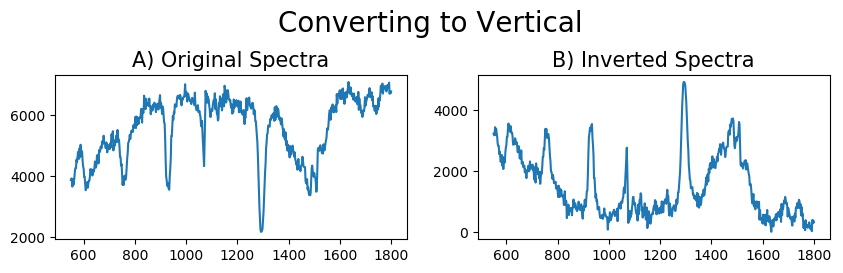

In [351]:
filename = "./_datas/felixfile.felix"

data = np.genfromtxt(filename)
x, y = data[:,0], data[:,2]
y1 = y.max()-y

plt.figure(1)

plt.suptitle("Converting to Vertical", fontsize = 20)

plt.subplot(221)
plt.plot(x, y)
plt.title("A) Original Spectra", fontsize = 15)

plt.subplot(222)
plt.plot(x, y1)
plt.title("B) Inverted Spectra", fontsize = 15)

plt.subplots_adjust(top=0.85)
plt.show()

# Baseline Correction

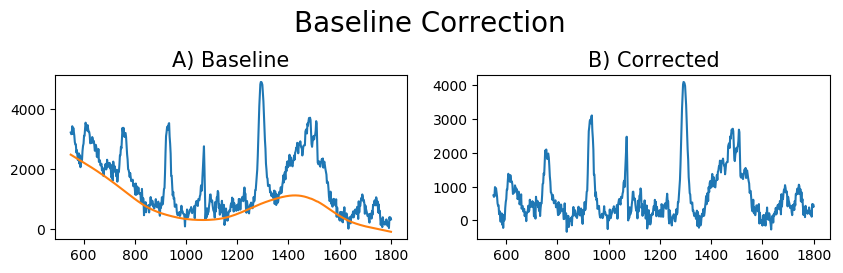

In [368]:
bir = np.array([[750., 920., 1300.]]) # the frequency regions devoid of signal, used by rp.baseline()

lamb = 10e4
p_value = 0.01
iterations = 10

y_corrected, background = rp.baseline(x, y1,bir,"als",lam = lamb, p = p_value, niter = iterations)

plt.figure(1)

plt.suptitle("Baseline Correction", fontsize = 20)

plt.subplot(221)
plt.plot(x, y1,label="raw data")
plt.plot(x,background,label="background")
plt.title("A) Baseline", fontsize = 15)

plt.subplot(222)
plt.plot(x,y_corrected,label="corrected signal")
plt.title("B) Corrected", fontsize = 15)

plt.subplots_adjust(top=0.85)
plt.show()

# The lambda value can be used to change the baseline.

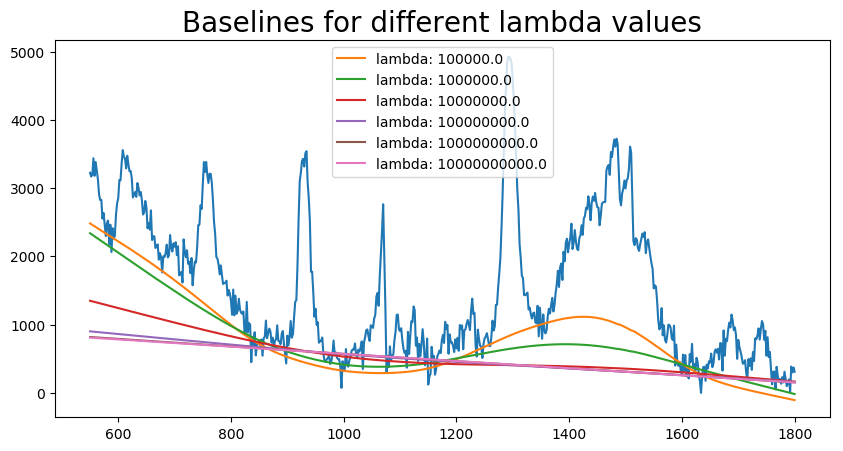

In [336]:
bir = np.array([[750., 920., 1300.]]) # the frequency regions devoid of signal, used by rp.baseline()

lamb = [10e4, 10e5, 10e6, 10e7, 10e8, 10e9]
plt.figure(1)

plt.plot(x,y1)
for i in lamb:
    y_corrected, background = rp.baseline(x, y1,bir,"als",lam = i)
    plt.plot(x,background,label='lambda: %s'%i)
    
plt.title("Baselines for different lambda values", fontsize = 20)
plt.legend()

In [334]:
help(rp.baseline)

Help on function baseline in module rampy.baseline:

baseline(x_input, y_input, bir, method, **kwargs)
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    y_input : ndarray
        y values.
    bir : ndarray
        Contain the regions of interest, organised per line. 
        For instance, roi = np.array([[100., 200.],[500.,600.]]) will 
        define roi between 100 and 200 as well as between 500 and 600.
        Note: This is NOT used by the "als" and "arPLS" algorithms, but still is a requirement when calling the function.
        bir and method probably will become args in a futur iteration of rampy to solve this.
    methods : str
        "poly": polynomial fitting, with splinesmooth the degree of the polynomial.
        "unispline": spline with the UnivariateSpline function of Scipy, splinesmooth is 
                     the spline smoothing factor (assume equal weight in the present case);
    